In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, Subset
from torchvision import transforms
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import medmnist
from medmnist import BloodMNIST
from medmnist import INFO
import numpy as np
from PIL import Image
import random



In [2]:
class BloodCellClassifier(nn.Module):
    def __init__(self):
        super(BloodCellClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
def train_validate(model, train_dataloader, val_dataloader, criterion, optimizer, device, num_epochs=10):
    
    model = model.to(device)
    
    train_losses = []
    val_losses = []
    val_accs = []
    val_precisions = []
    val_recalls = []
    val_f1s = []

    for epoch in range(num_epochs):
        
        model.train()
        running_train_loss = 0.0
        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        model.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0
        
        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for images, labels in val_dataloader:
                images = images.to(device)
                labels = labels.squeeze().long().to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_predictions.append(predicted)
                all_labels.append(labels)

        avg_val_loss = running_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        val_acc = 100 * correct / total
        val_accs.append(val_acc)

        all_predictions = torch.cat(all_predictions).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        val_precision = precision_score(all_labels, all_predictions, average='macro')
        val_recall = recall_score(all_labels, all_predictions, average='macro')
        val_f1 = f1_score(all_labels, all_predictions, average='macro')

        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_acc:.2f}% | "
              f"Val Precision: {val_precision:.4f} | "
              f"Val Recall: {val_recall:.4f} | "
              f"Val F1: {val_f1:.4f}")

   
    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accs": val_accs,
        "val_precisions": val_precisions,
        "val_recalls": val_recalls,
        "val_f1s": val_f1s,
    }

In [8]:
def plot_val_metrics(metrics):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    epochs = range(1, len(metrics['train_losses']) + 1)

    ax1.plot(epochs, metrics['val_losses'], color='red')
    ax1.set_title('Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    ax2.plot(epochs, metrics['val_accs'], color='blue')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


In [19]:
info = INFO['bloodmnist']
task = info['task']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

trainset = DataClass(split='train', transform=transforms.ToTensor(), download=True)
valset   = DataClass(split='val', transform=transforms.ToTensor(), download=True)
testset  = DataClass(split='test', transform=transforms.ToTensor(), download=True)

train_dataloader = data.DataLoader(dataset=trainset, batch_size=128, shuffle=True)
val_dataloader   = data.DataLoader(dataset=valset, batch_size=128, shuffle=False)
test_dataloader  = data.DataLoader(dataset=testset, batch_size=128, shuffle=False)

def extract_unique_labels(dataset):
    unique_labels = set()
    for _, label in dataset:
        if isinstance(label, np.ndarray):
            label = int(label[0])
        unique_labels.add(label)
    return sorted(list(unique_labels))

classes = extract_unique_labels(trainset)

label_counts = {}

for data, target in train_dataloader:
    for label in target:
        label = label.item() 
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

for label, count in label_counts.items():
    print(f'Label {label}: {count} images')

print(f"Train size: {len(trainset)}")
print(f"Validation size: {len(valset)}")
print(f"Test size: {len(testset)}")

Label 3: 2026 images
Label 1: 2181 images
Label 6: 2330 images
Label 5: 993 images
Label 7: 1643 images
Label 4: 849 images
Label 0: 852 images
Label 2: 1085 images
Train size: 11959
Validation size: 1712
Test size: 3421


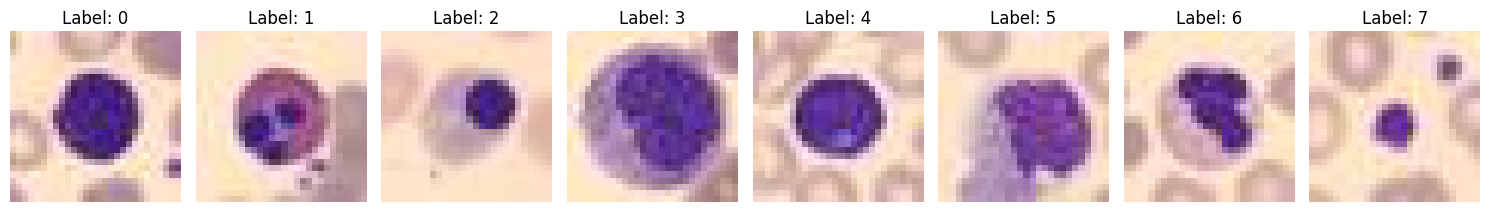

In [20]:
plt.figure(figsize=(15, 5))

encountered_labels = [False] * n_classes

for i in range(len(trainset)):
    image, label = trainset[i]

    label = label.item()

    if not encountered_labels[label]:
        plt.subplot(1, n_classes, label+1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f'Label: {classes[label]}')
        plt.axis('off')

        encountered_labels[label] = True
    if all(encountered_labels):
        break

plt.tight_layout()
plt.show()

Epoch 1/10 | Train Loss: 1.3118 | Val Loss: 0.8349 | Val Acc: 70.33% | Val Precision: 0.7422 | Val Recall: 0.6243 | Val F1: 0.6288
Epoch 2/10 | Train Loss: 0.7720 | Val Loss: 0.6841 | Val Acc: 75.82% | Val Precision: 0.7447 | Val Recall: 0.7122 | Val F1: 0.7125
Epoch 3/10 | Train Loss: 0.6624 | Val Loss: 0.6046 | Val Acc: 77.80% | Val Precision: 0.7709 | Val Recall: 0.7257 | Val F1: 0.7180
Epoch 4/10 | Train Loss: 0.5921 | Val Loss: 0.5424 | Val Acc: 79.67% | Val Precision: 0.7897 | Val Recall: 0.7587 | Val F1: 0.7616
Epoch 5/10 | Train Loss: 0.5168 | Val Loss: 0.5066 | Val Acc: 81.60% | Val Precision: 0.8051 | Val Recall: 0.7688 | Val F1: 0.7739
Epoch 6/10 | Train Loss: 0.4689 | Val Loss: 0.4319 | Val Acc: 85.22% | Val Precision: 0.8296 | Val Recall: 0.8427 | Val F1: 0.8320
Epoch 7/10 | Train Loss: 0.4229 | Val Loss: 0.3720 | Val Acc: 87.03% | Val Precision: 0.8481 | Val Recall: 0.8537 | Val F1: 0.8494
Epoch 8/10 | Train Loss: 0.3835 | Val Loss: 0.3845 | Val Acc: 84.93% | Val Precisio

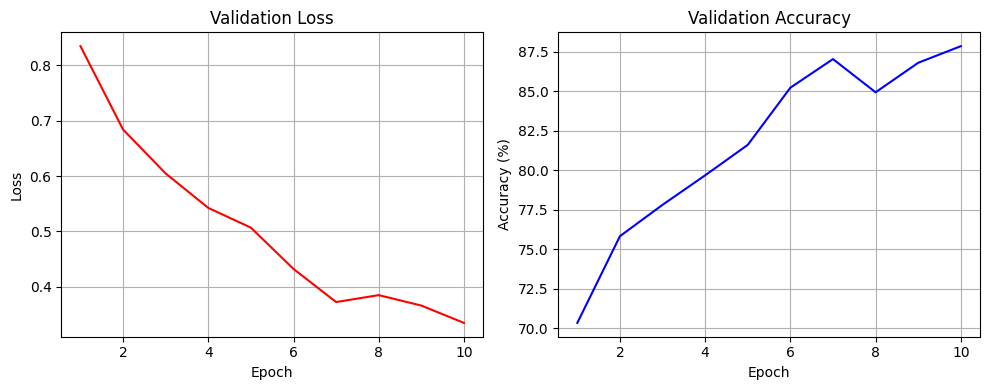

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BloodCellClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

original_metrics = train_validate(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=10
)

plot_val_metrics(original_metrics)

In [37]:
class GeneratedBloodMNIST(Dataset):
    def __init__(self, data_path, label_path, transform=None):
        self.images = np.load(data_path)  
        self.labels = np.load(label_path)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8)

        if image.ndim == 2: 
            image = Image.fromarray(image).convert("RGB")
        else:
            image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return image, label

In [38]:
generated_dataset = GeneratedBloodMNIST(
    data_path='./generated_blood_cell_images1/generated_train_data.npy',
    label_path='./generated_blood_cell_images1/generated_train_labels.npy',
    transform=transforms.ToTensor()
)

total_size = len(generated_dataset)
generated_train_size = int(0.7 * total_size)
generated_val_size = int(0.1 * total_size)
generated_test_size = total_size - generated_train_size - generated_val_size

generated_trainset, generated_valset, generated_testset = random_split(
    generated_dataset,
    [generated_train_size, generated_val_size, generated_test_size],
    generator=torch.Generator().manual_seed(42)
)

generated_train_dataloader = DataLoader(generated_trainset, batch_size=128, shuffle=True)
generated_val_dataloader   = DataLoader(generated_valset, batch_size=128, shuffle=False)
generated_test_dataloader  = DataLoader(generated_testset, batch_size=128, shuffle=False)

print(f"Train size: {len(generated_trainset)}")
print(f"Validation size: {len(generated_valset)}")
print(f"Test size: {len(generated_testset)}")

Train size: 5600
Validation size: 800
Test size: 1600


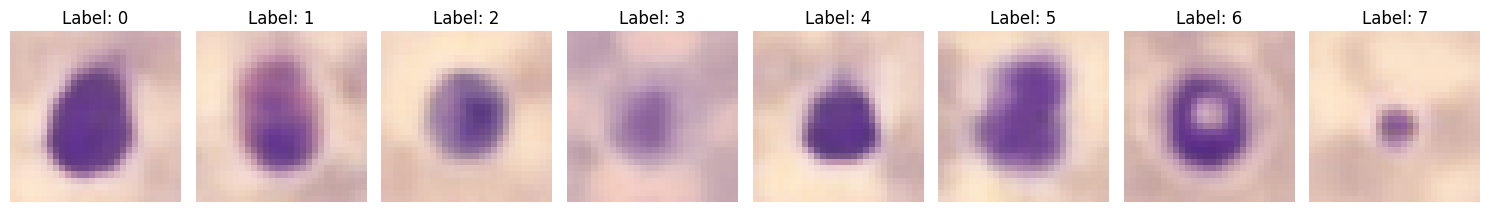

In [41]:
plt.figure(figsize=(15, 5))

encountered_labels = [False] * n_classes

for i in range(len(generated_trainset)):
    image, label = generated_trainset[i]

    label = int(label)

    if not encountered_labels[label]:
        plt.subplot(1, n_classes, label+1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f'Label: {classes[label]}')
        plt.axis('off')

        encountered_labels[label] = True
    if all(encountered_labels):
        break

plt.tight_layout()
plt.show()

Epoch 1/10 | Train Loss: 1.7992 | Val Loss: 1.0962 | Val Acc: 75.88% | Val Precision: 0.8137 | Val Recall: 0.7500 | Val F1: 0.7394
Epoch 2/10 | Train Loss: 0.7774 | Val Loss: 0.5742 | Val Acc: 79.38% | Val Precision: 0.8405 | Val Recall: 0.7996 | Val F1: 0.7916
Epoch 3/10 | Train Loss: 0.4767 | Val Loss: 0.3925 | Val Acc: 86.50% | Val Precision: 0.8845 | Val Recall: 0.8618 | Val F1: 0.8648
Epoch 4/10 | Train Loss: 0.3934 | Val Loss: 0.3690 | Val Acc: 86.75% | Val Precision: 0.8822 | Val Recall: 0.8658 | Val F1: 0.8659
Epoch 5/10 | Train Loss: 0.3791 | Val Loss: 0.3583 | Val Acc: 86.88% | Val Precision: 0.8933 | Val Recall: 0.8675 | Val F1: 0.8708
Epoch 6/10 | Train Loss: 0.3379 | Val Loss: 0.2674 | Val Acc: 91.12% | Val Precision: 0.9147 | Val Recall: 0.9128 | Val F1: 0.9126
Epoch 7/10 | Train Loss: 0.2958 | Val Loss: 0.2799 | Val Acc: 89.88% | Val Precision: 0.9231 | Val Recall: 0.8972 | Val F1: 0.8977
Epoch 8/10 | Train Loss: 0.2896 | Val Loss: 0.2919 | Val Acc: 89.38% | Val Precisio

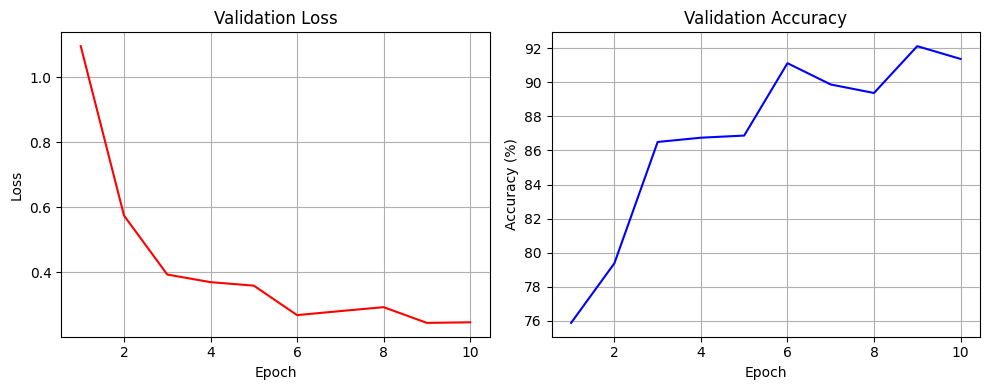

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BloodCellClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

generated_metrics = train_validate(
    model=model,
    train_dataloader=generated_train_dataloader,
    val_dataloader=generated_val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=10
)

plot_val_metrics(generated_metrics)

In [47]:
# bloodMNIST ima label kao numpy array
class FixedBloodMNIST(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]

        if isinstance(label, np.ndarray):
            label = int(label.item())
        label = torch.tensor(label, dtype=torch.long)

        return image, label

Epoch 1/10 | Train Loss: 1.2668 | Val Loss: 0.9580 | Val Acc: 67.79% | Val Precision: 0.7084 | Val Recall: 0.6463 | Val F1: 0.6533
Epoch 2/10 | Train Loss: 0.7753 | Val Loss: 0.6350 | Val Acc: 78.26% | Val Precision: 0.7707 | Val Recall: 0.7591 | Val F1: 0.7597
Epoch 3/10 | Train Loss: 0.6357 | Val Loss: 0.5412 | Val Acc: 81.17% | Val Precision: 0.8042 | Val Recall: 0.7965 | Val F1: 0.7918
Epoch 4/10 | Train Loss: 0.5295 | Val Loss: 0.4557 | Val Acc: 84.28% | Val Precision: 0.8369 | Val Recall: 0.8311 | Val F1: 0.8297
Epoch 5/10 | Train Loss: 0.4470 | Val Loss: 0.4356 | Val Acc: 84.55% | Val Precision: 0.8591 | Val Recall: 0.8155 | Val F1: 0.8234
Epoch 6/10 | Train Loss: 0.3848 | Val Loss: 0.3400 | Val Acc: 89.13% | Val Precision: 0.8846 | Val Recall: 0.8826 | Val F1: 0.8828
Epoch 7/10 | Train Loss: 0.3531 | Val Loss: 0.3271 | Val Acc: 88.77% | Val Precision: 0.8773 | Val Recall: 0.8869 | Val F1: 0.8765
Epoch 8/10 | Train Loss: 0.3155 | Val Loss: 0.3815 | Val Acc: 87.46% | Val Precisio

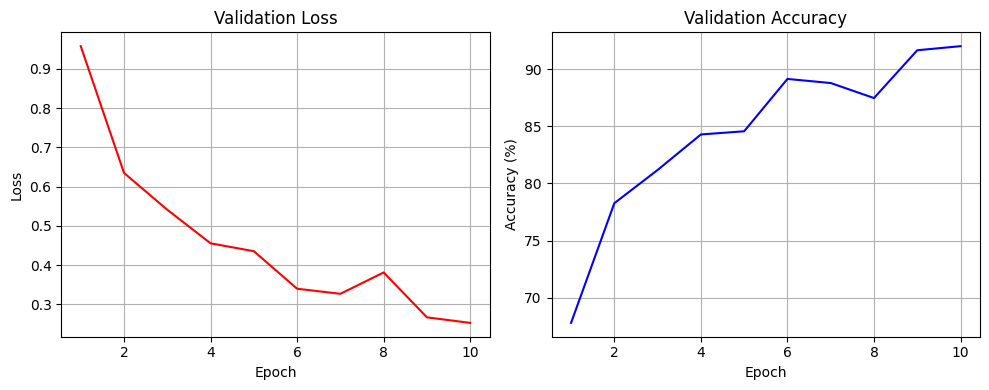

In [50]:
combined_trainset = ConcatDataset([FixedBloodMNIST(trainset), generated_trainset])
combined_valset = ConcatDataset([FixedBloodMNIST(valset), generated_valset])
combined_testset = ConcatDataset([FixedBloodMNIST(testset), generated_testset])

combined_train_loader = DataLoader(combined_trainset, batch_size=128, shuffle=True)
combined_val_dataloader = DataLoader(combined_valset, batch_size=128, shuffle=False)
combined_test_dataloader = DataLoader(combined_testset, batch_size=128, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BloodCellClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

combined_metrics = train_validate(
    model=model,
    train_dataloader=combined_train_loader,
    val_dataloader=combined_val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=10
)

plot_val_metrics(combined_metrics)

In [59]:
def balance_dataset(original_dataset, generated_dataset, target_per_class, classes):

    def indices_by_label(dataset, label):
        return [i for i, (_, lbl) in enumerate(dataset) if int(lbl) == label]

    balanced_indices = []
    combined_dataset = ConcatDataset([original_dataset, generated_dataset])
    offset = len(original_dataset)

    for label in classes:
        original_indices = indices_by_label(original_dataset, label)
        generated_indices = indices_by_label(generated_dataset, label)

        random.shuffle(original_indices)
        random.shuffle(generated_indices)

        total_available = len(original_indices) + len(generated_indices)

        if total_available <= target_per_class:
            chosen_orig = original_indices
            chosen_gen_shifted = [i + offset for i in generated_indices]
            balanced_indices.extend(chosen_orig + chosen_gen_shifted)
        else:
            needed_from_gen = target_per_class - len(original_indices)
            needed_from_gen = max(0, needed_from_gen)
            chosen_orig = original_indices[:target_per_class]
            chosen_gen_shifted = [i + offset for i in generated_indices[:needed_from_gen]]
            balanced_indices.extend(chosen_orig + chosen_gen_shifted)

    return Subset(combined_dataset, balanced_indices)


In [60]:
target_per_class = 2500

balanced_dataset = balance_dataset(FixedBloodMNIST(ConcatDataset([trainset, valset, testset])), generated_dataset, target_per_class, classes)

balanced_size = len(balanced_dataset)
balanced_train_size = int(0.7 * balanced_size)
balanced_val_size = int(0.1 * balanced_size)
balanced_test_size = balanced_size - balanced_train_size - balanced_val_size

balanced_trainset, balanced_valset, balanced_testset = random_split(
    balanced_dataset,
    [balanced_train_size, balanced_val_size, balanced_test_size],
    generator=torch.Generator().manual_seed(42)
)

balanced_train_dataloader = DataLoader(balanced_trainset, batch_size=128, shuffle=True)
balanced_val_dataloader   = DataLoader(balanced_valset, batch_size=128, shuffle=False)
balanced_test_dataloader  = DataLoader(balanced_testset, batch_size=128, shuffle=False)

print(f"Train size: {len(balanced_trainset)}")
print(f"Validation size: {len(balanced_valset)}")
print(f"Test size: {len(balanced_testset)}")

Train size: 13546
Validation size: 1935
Test size: 3871


In [61]:
label_counts = {}

for data, target in balanced_train_dataloader:
    for label in target:
        label = label.item() 
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

for label, count in label_counts.items():
    print(f'Label {label}: {count} images')


Label 0: 1544 images
Label 6: 1730 images
Label 4: 1554 images
Label 3: 1749 images
Label 7: 1784 images
Label 2: 1774 images
Label 5: 1704 images
Label 1: 1707 images


Epoch 1/10 | Train Loss: 1.3186 | Val Loss: 1.0386 | Val Acc: 62.69% | Val Precision: 0.6551 | Val Recall: 0.6304 | Val F1: 0.6179
Epoch 2/10 | Train Loss: 0.8738 | Val Loss: 0.8176 | Val Acc: 73.07% | Val Precision: 0.7252 | Val Recall: 0.7281 | Val F1: 0.7256
Epoch 3/10 | Train Loss: 0.7229 | Val Loss: 0.7323 | Val Acc: 73.59% | Val Precision: 0.7525 | Val Recall: 0.7343 | Val F1: 0.7340
Epoch 4/10 | Train Loss: 0.6441 | Val Loss: 0.6691 | Val Acc: 77.05% | Val Precision: 0.7813 | Val Recall: 0.7713 | Val F1: 0.7560
Epoch 5/10 | Train Loss: 0.5472 | Val Loss: 0.5709 | Val Acc: 81.55% | Val Precision: 0.8362 | Val Recall: 0.8105 | Val F1: 0.8118
Epoch 6/10 | Train Loss: 0.4902 | Val Loss: 0.4836 | Val Acc: 85.17% | Val Precision: 0.8475 | Val Recall: 0.8503 | Val F1: 0.8481
Epoch 7/10 | Train Loss: 0.4285 | Val Loss: 0.4579 | Val Acc: 85.43% | Val Precision: 0.8571 | Val Recall: 0.8526 | Val F1: 0.8514
Epoch 8/10 | Train Loss: 0.4038 | Val Loss: 0.4629 | Val Acc: 84.70% | Val Precisio

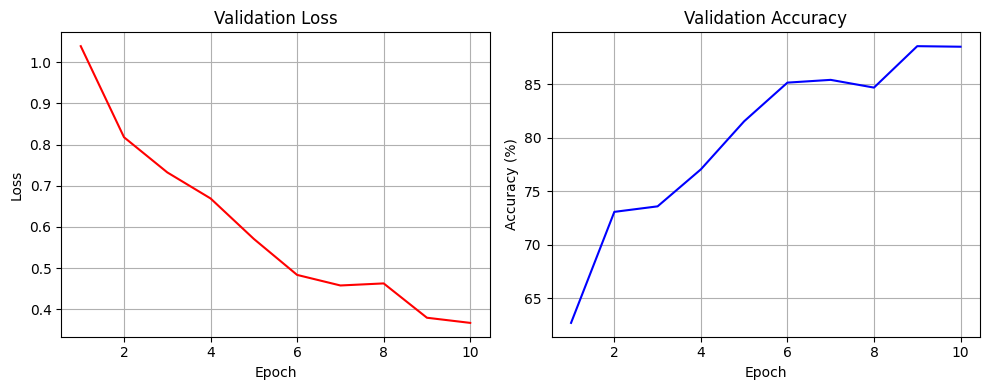

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BloodCellClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

balanced_metrics = train_validate(
    model=model,
    train_dataloader=balanced_train_dataloader,
    val_dataloader=balanced_val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=10
)

plot_val_metrics(balanced_metrics)

In [63]:
class BlurredDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        if isinstance(label, np.ndarray):
            label = int(label.item())
        label = torch.tensor(label, dtype=torch.long)

        return image, label


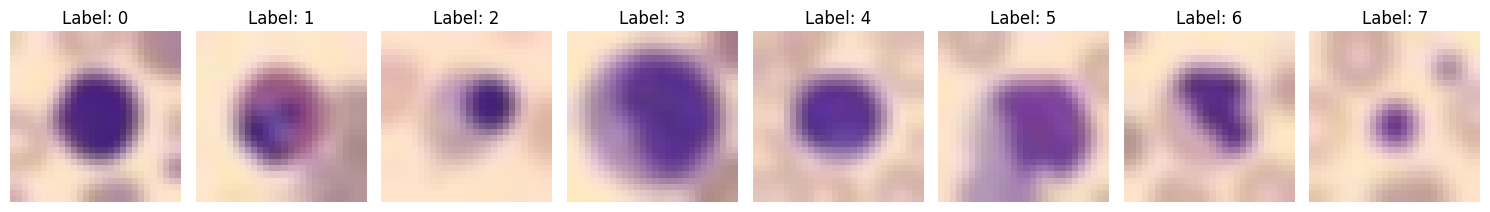

In [64]:
blur_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.GaussianBlur(kernel_size=5, sigma=(1, 4.0)),
    transforms.ToTensor()
])

blurred_trainset = BlurredDataset(trainset, blur_transform)
blurred_valset = BlurredDataset(valset, blur_transform)
blurred_testset = BlurredDataset(testset, blur_transform)


plt.figure(figsize=(15, 5))

encountered_labels = [False] * n_classes

for i in range(len(blurred_trainset)):
    image, label = blurred_trainset[i]

    label = int(label)

    if not encountered_labels[label]:
        plt.subplot(1, n_classes, label+1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f'Label: {classes[label]}')
        plt.axis('off')

        encountered_labels[label] = True
    if all(encountered_labels):
        break

plt.tight_layout()
plt.show()

In [67]:
target_per_class = 2500

blurred_balanced_dataset = balance_dataset(ConcatDataset([blurred_trainset, blurred_valset, blurred_testset]), generated_dataset, target_per_class, classes)

blurred_balanced_size = len(blurred_balanced_dataset)
blurred_balanced_train_size = int(0.7 * blurred_balanced_size)
blurred_balanced_val_size = int(0.1 * blurred_balanced_size)
blurred_balanced_test_size = blurred_balanced_size - blurred_balanced_train_size - blurred_balanced_val_size

blurred_balanced_trainset, blurred_balanced_valset, blurred_balanced_testset = random_split(
    blurred_balanced_dataset,
    [blurred_balanced_train_size, blurred_balanced_val_size, blurred_balanced_test_size],
    generator=torch.Generator().manual_seed(42)
)

blurred_balanced_train_dataloader = DataLoader(blurred_balanced_trainset, batch_size=128, shuffle=True)
blurred_balanced_val_dataloader   = DataLoader(blurred_balanced_valset, batch_size=128, shuffle=False)
blurred_balanced_test_dataloader  = DataLoader(blurred_balanced_testset, batch_size=128, shuffle=False)

print(f"Train size: {len(blurred_balanced_trainset)}")
print(f"Validation size: {len(blurred_balanced_valset)}")
print(f"Test size: {len(blurred_balanced_testset)}")

label_counts = {}

for data, target in blurred_balanced_train_dataloader:
    for label in target:
        label = label.item() 
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

for label, count in label_counts.items():
    print(f'Label {label}: {count} images')

Train size: 13546
Validation size: 1935
Test size: 3871
Label 4: 1554 images
Label 7: 1784 images
Label 5: 1704 images
Label 2: 1774 images
Label 6: 1730 images
Label 0: 1544 images
Label 3: 1749 images
Label 1: 1707 images


Epoch 1/10 | Train Loss: 1.3751 | Val Loss: 1.0588 | Val Acc: 63.77% | Val Precision: 0.6700 | Val Recall: 0.6454 | Val F1: 0.6300
Epoch 2/10 | Train Loss: 0.8638 | Val Loss: 0.8474 | Val Acc: 71.47% | Val Precision: 0.7382 | Val Recall: 0.7080 | Val F1: 0.7104
Epoch 3/10 | Train Loss: 0.6874 | Val Loss: 0.6916 | Val Acc: 77.21% | Val Precision: 0.7980 | Val Recall: 0.7657 | Val F1: 0.7677
Epoch 4/10 | Train Loss: 0.5968 | Val Loss: 0.6059 | Val Acc: 79.64% | Val Precision: 0.8040 | Val Recall: 0.7955 | Val F1: 0.7829
Epoch 5/10 | Train Loss: 0.5446 | Val Loss: 0.5526 | Val Acc: 82.33% | Val Precision: 0.8282 | Val Recall: 0.8212 | Val F1: 0.8179
Epoch 6/10 | Train Loss: 0.4918 | Val Loss: 0.5143 | Val Acc: 83.31% | Val Precision: 0.8411 | Val Recall: 0.8302 | Val F1: 0.8280
Epoch 7/10 | Train Loss: 0.4321 | Val Loss: 0.4666 | Val Acc: 86.25% | Val Precision: 0.8696 | Val Recall: 0.8595 | Val F1: 0.8618
Epoch 8/10 | Train Loss: 0.4089 | Val Loss: 0.4346 | Val Acc: 86.67% | Val Precisio

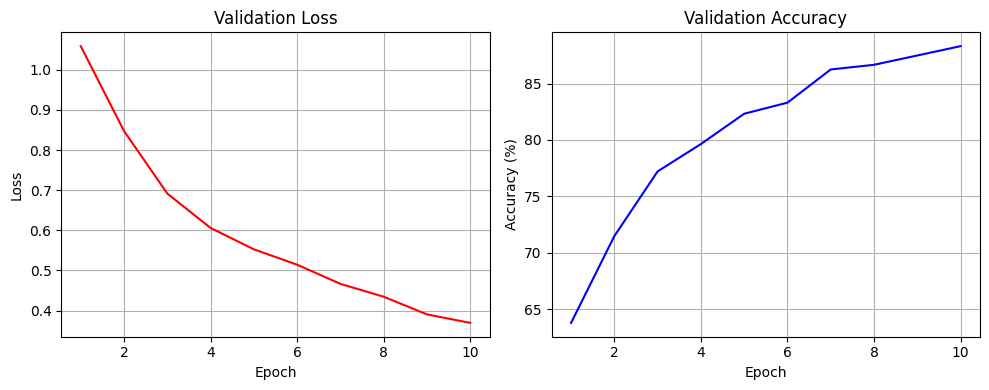

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BloodCellClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

blurred_balanced_metrics = train_validate(
    model=model,
    train_dataloader=balanced_train_dataloader,
    val_dataloader=balanced_val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=10
)

plot_val_metrics(blurred_balanced_metrics)